# Accelerated Gradient Descent and Newton's Method
> "From scratch implementation of accelerated GD and Newton's method using a funky gamma-distributed loss function"
- toc: false
- branch: master
- badges: true
- comments: true
- image: images/Hess.png
- hide: false
- search_exclude: false

Nonconvex optimization problems are ubiquitous in modern machine learning. While it is NP-hard to find global minima of a nonconvex function in the worst case, in the setting of machine learning it has proved useful to consider a less stringent notion of success, namely that of convergence to a first-order stationary point. However, architectures such as deep neural networks induce optimization surfaces that can be teeming with highly suboptimal saddle points.

In this setting, the glaring limitation of gradient descent is that it can get stuck in flat areas or bounce around if the objective function returns noisy gradients. Therefore second-order descent methods are needed for optimization. Momentum is an approach that accelerates the progress of the search to skim across flat areas and smooth out bouncy gradients. In some cases, the acceleration of momentum can cause the search to miss or overshoot the minima at the bottom of basins or valleys. Nesterov momentum is an extension of momentum that involves calculating the decaying moving average of the gradients of projected positions in the search space rather than the actual positions themselves. This has the effect of harnessing the accelerating benefits of momentum whilst allowing the search to slow down when approaching the optima and reduce the likelihood of missing or overshooting it. Further, Nesterov’s accelerated gradient descent (AGD), an instance of the general family of “momentum methods,” provably achieves faster convergence rate than gradient descent (GD) in the convex setting.

$$ L(\alpha,\beta|y_1,...,y_n) = \prod_{i=1}^{n}\frac{\Gamma (\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}y_i^{\alpha-1}(1-y_i)^{\beta-1} $$

Given the above likelihood function, where $\Gamma$ is the gamma function, and $\alpha$ and $\beta$ are greater than zero. First, we convert our likelihood function to the log likelihood. 

$$ log(L(\alpha, \beta | y_{1}, ..., y_{n})) = nlog(\Gamma(a+b)) -nlog(\Gamma(a)) -nlog(\Gamma(b)) +(a-1)\sum_{i=1}^{n}log(y_{i}) +(b-1)\sum_{i=1}^{n}log(1-y_{i}) $$

And its maximum likelihood formulation.

$$ \widehat{\alpha}, \widehat{\beta} = \underset{i}{argmax}(log(\widehat{L}(\alpha, \beta | y_{1}, ..., y_{n}))) $$

And our gradient and Hessian from the log likelihood function:

&emsp; Gradient

$$ 
\bigtriangledown log(L)) =
\begin{bmatrix}
n\psi(\alpha+\beta) -n\psi(\alpha) +\sum_{i=1}^{n}log(y_{i})
\\ 
n\psi(\alpha+\beta) -n\psi(\beta) +\sum_{i=1}^{n}log(1-y_{i})
\end{bmatrix}
$$

&emsp; Hessian

$$ \bigtriangledown^{2} log(L) =
\begin{bmatrix}
n\psi'(\alpha+\beta) -n\psi'(\alpha) & n\psi'(\alpha+\beta)
\\ 
 n\psi'(\alpha+\beta) & n\psi'(\alpha+\beta) -n\psi'(\beta)  
\end{bmatrix}
$$

#### Let's code it up.
For digamma $\psi(x) = \frac{\Gamma'(x)}{\Gamma(x)}$ and trigamma $\psi'(x)$, we will cheat and use built-in functions from scipy.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.io import loadmat
import seaborn as sns
import scipy
from sklearn.model_selection import KFold, cross_val_score
from random import randrange
from scipy.interpolate import BSpline
from scipy.ndimage import gaussian_filter
%matplotlib inline
from scipy.special import digamma, polygamma

Loading the data and coding our objective function, gradient, and Hessian.

In [ ]:
Y = loadmat('Sample_data.mat')['y']

In [ ]:
def objective(data, x):
    n = len(data)
    return n*math.log(math.gamma(x[0]+x[1]))-n*math.log(math.gamma(x[0]))-n*math.log(math.gamma(x[1])) + (x[0]-1)*sum([math.log(i) for i in data]) + (x[1]-1)*sum([math.log(1-i) for i in data]) 

def gradient(data, x):
    n = len(data)
    return np.array([n* digamma(x[0]+x[1]) - n*digamma(x[0]) + sum([math.log(i) for i in data]), n* digamma(x[0]+x[1]) - n*digamma(x[1]) + sum([math.log(1-i) for i in data])]) 

def Hessian(data, x):
    n = len(data)
    return np.array([[n* polygamma(1, x[0]+x[1]) - n*polygamma(1, x[0]), n* polygamma(1, x[0]+x[1])],[n* polygamma(1, x[0]+x[1]), n* polygamma(1, x[0]+x[1]) - n*polygamma(1, x[1])]])

&emsp; Newton's Method

Text(0, 0.5, 'Log-Likelihood')

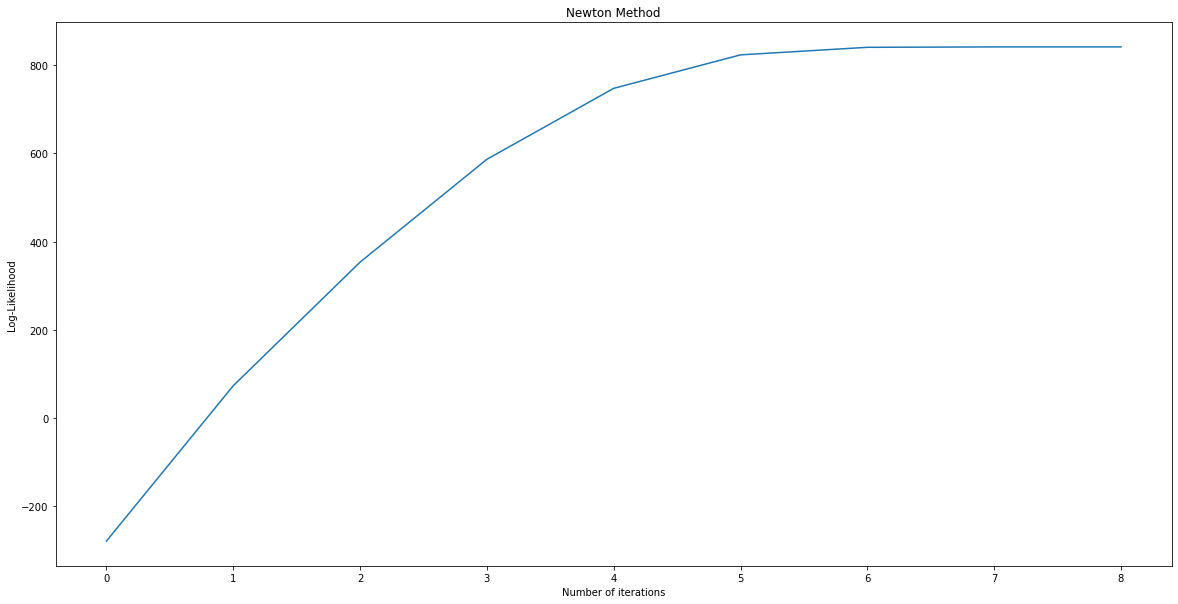

In [ ]:
alpha = 1 
lam = 1e-10
epsilon = 0.01
x0 = np.random.rand(2)

f0 = objective(Y, x0) # initialize
fL = [f0]
g0  = gradient(Y, x0) # initialize
gL = [g0]
H0 = Hessian(Y, x0) # initialize
Omega = -np.linalg.solve(H0 + lam*np.eye(2),g0)
stopping = np.linalg.norm(Omega)
iterations = 1
params = []
while stopping > epsilon:
    x = x0 + alpha*Omega 
    fval = objective(Y, x)
    while fval < f0: 
        alpha *= 0.1
        x = x0 + alpha*Omega 
        fval = objective(Y, x)
    alpha = alpha**0.5
    params.append(x)
    x0 = x
    f0 = fval
    fL.append(fval)
    g0 = gradient(Y, x0)
    Omega = -np.linalg.solve(Hessian(Y, x0)+lam*np.eye(2),g0)
    stopping = np.linalg.norm(Omega)
    iterations += 1

results = x0
iters = iterations

plt.figure(figsize=(20,10))
plt.plot(fL)
plt.title('Newton Method')
plt.xlabel('Number of iterations')
plt.ylabel('Log-Likelihood')

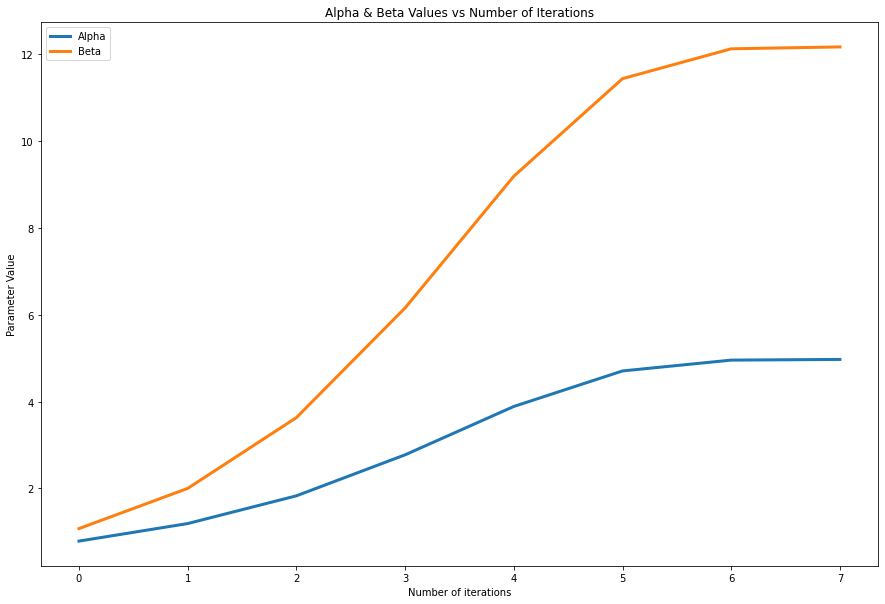

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot([x[0] for x in params], lw=3, label='Alpha')
ax.plot([x[1] for x in params], lw = 3, label='Beta')
plt.title('Alpha & Beta Values vs Number of Iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Parameter Value')
ax.legend(loc='best')

In [ ]:
print(f" Newton's Method optimized parameter values- Alpha: {round(x0[0], 3)}, Beta: {round(x0[1], 3)}")

 Newton's Method optimized parameter values- Alpha: 4.97, Beta: 12.173


&emsp; Accelerated Gradient Descent

In [ ]:
x = np.random.rand(2)
beta = np.random.rand(2) 
x0 = x 

convergence = gradient(Y, beta)@gradient(Y, beta)
convergence_results = [convergence]
loss = [objective(Y, x)]
alpha = 0.1
epsilon = 0.01
iterations = 1
while convergence > epsilon:
    x = beta + alpha*gradient(Y, x)
    beta = x - (iterations-1)/(iterations+2)*(x-x0)
    convergence = gradient(Y, x)@gradient(Y, x)
    convergence_results.append(convergence)
    try:
        loss.append(objective(Y, x))
    except:
        pass
    x0 = x
    iterations += 1
    
results = x0
iters = iterations

plt.figure(figsize=(20,10))
plt.plot(loss)
plt.title('Accelerated Gradient Descent')
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')